---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **SEM-EX CORRELATION ANALYSIS**

### Import Libraries

In [1]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from scipy.special import softmax
import numpy as np
from src.models.Clustering_Correlation_Analysis.src.util import util_preprocessing_data, util_plots


# 1) BASELINE: Clinical features alone
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Features and Targets and Convert Data to Arrays
we need to separate the data into the features and targets. The target, also known as the label, is the value we want to predict,
 in this case the actual max temperature and the features are all the columns the model uses to make a prediction.
 We will also convert the Pandas dataframes to Numpy arrays because that is the way the algorithm works. (I save the column headers, which are the names of the features, to a list to use for later visualization).

* Preprocessing
    1) Labels and Features Separation;
    2) Fill Nan type operations
    3) OneHotEncoding of Data;
    4) Standardize Data;



In [2]:


# Data Import
Clinical_Claro_features = pd.read_excel(r'C:\Users\Ruffi\Desktop\Deep_clustering_SEM-EX\src\models\Clustering_Correlation_Analysis\data\RETRO_PR_Dataset_Clinical.xlsx', index_col=1).drop(columns=['Unnamed: 0'])
display(Clinical_Claro_features)


# Common Parameters ( TODO pass to yaml file )
fillnan = 0
random_state = 42
n_splits = 10

# Bootstrap Parameters:

n_iterations = 20
size_perc  =  0.80


# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 1.1) Labels are the values we want to predict:
Y = Clinical_Claro_features.pop('label OS').astype(int)
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 1.2) Features for training:
X_raw= Clinical_Claro_features.copy(deep=True)
# Features that too much related to labels:
X_raw = X_raw.drop(columns=[ 'Stato'])

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 2.1) Fill-Nan Operations:
X_raw['cT'] = pd.to_numeric( X_raw['cT']).fillna(fillnan)
X_raw['cN'] = pd.to_numeric( X_raw['cN']).fillna(fillnan)
X_raw['cM'] = pd.to_numeric( X_raw['cM']).fillna(fillnan)


# 3) Obtain the One Hot encoding of all the Data
X = pd.get_dummies(X_raw)
#4) kf StratifiedKFold
kf=StratifiedKFold(n_splits=n_splits)

,Sesso,Stadio,Stato,Trattamento,Diagnosi,cT,cN,Età,cM,CT_concomitante,Chirurgia,label OS
ID paziente,,,,,,,,,,,,
9309,f,iiia,doc,radio,carcinoma squamoso,2.0,2.0,86,0,1,0,0
40158,m,iiia,dod,radio,carcinoma squamoso,3.0,2.0,72,0,0,0,0
51236,f,iiia,awd,radio,adenocarcinoma,NaN,2.0,58,0,0,0,1
52384,m,iiib,ned,radio,carcinoma squamoso,4.0,1.0,73,0,1,0,1
58391,m,iiib,awd,radio,carcinoma squamoso,3.0,2.0,75,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
100151470,m,iiib,dod,altro,adenocarcinoma,3.0,3.0,77,0,1,0,0
100189360,m,iiib,doc,radio,carcinoma squamoso,4.0,2.0,63,0,1,0,0
100237360,f,iiia,awd,radio,carcinoma squamoso,2.0,2.0,70,0,0,0,1



### 1) Training and Testing Sets Splitting:
During training, we let the model ‘see’ the answers, in this case the actual temperature, so it can learn how to predict the temperature from the features. We expect there to be some relationship between all the features and the target value, and the model’s job is to learn this relationship during training. Then, when it comes time to evaluate the model, we ask it to make predictions on a testing set where it only has access to the features (not the answers)! Because we do have the actual answers for the test set, we can compare these predictions to the true value to judge how accurate the model is. Generally, when training a model, we randomly split the data into training and testing sets to get a representation of all data points.
 I am setting the random state to 42 which means the results will be the same each time I run the split for reproducible results.
### K-fold Stratified Cross Validation
Hold-out is when you split up your dataset into a ‘train’ and ‘test’ set. The training set is what the model is trained on, and the test set is used to see how well that model performs on unseen data. A common split when using the hold-out method is using 80% of data for training and the remaining 20% of the data for testing


## 2) Train Model
After all the work of data preparation, creating and training the model is pretty simple using Scikit-learn. We import the random forest regression model from skicit-learn, instantiate the model, and fit (scikit-learn’s name for training) the model on the training data. (Again setting the random state for reproducible results). This entire process is only 3 lines in scikit-learn!
### Instantiate the model to train: RF Classifier and training

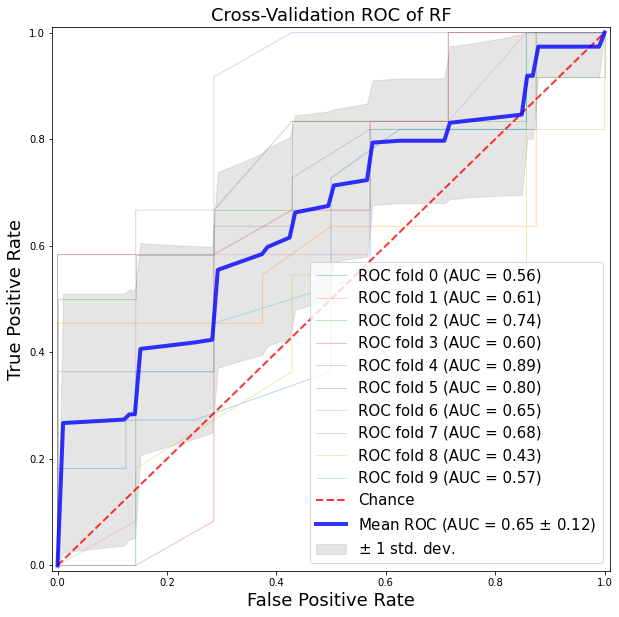

The accuracy of the model is:  59.88304093567252 +/- 0.06857083620101069 %


In [3]:

# Instantiate model with 1000 decision trees
rf_classifier = RandomForestClassifier(random_state=random_state)

# Plot the ROC curves combined
Accuracies_baseline, rf_classifier_baseline =  util_preprocessing_data.compute_training_acc_and_Combined_ROC_CURVE(X_train_res=X, y_train_res=Y, classifier=rf_classifier, kf=kf )


print(f"The accuracy of the model is:  { np.mean(list(Accuracies_baseline.values()))*100} +/- {np.std(list(Accuracies_baseline.values()))} %")

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.preprocessing import normalize
# Bootstrap
#Lets run Bootstrap
X_bootstrap = X.copy(deep=True)
X_bootstrap = pd.concat( [X_bootstrap, Y], axis=1)
X_values = X_bootstrap.values

n_size = int(len(X) * size_perc)
Accuracies_bootstrap = dict()
for i in range(n_iterations):

    # Prepare train & test sets
    train = resample(X_values, n_samples = n_size) #Sampling with replacement..whichever is not used in training data will be used in test data
    maximum_train =  train[:,:-1].max()
    minimum_train = train[:,:-1].min()
    train[:,:-1] = (train[:,:-1] - minimum_train) / (maximum_train - minimum_train)
    # Test Fold:
    train_ = pd.DataFrame(train[:,:-1])
    train_.drop_duplicates(keep='first')
    display(train_)

    test = np.array([x for x in X_values if x.tolist() not in train.tolist()]) #picking rest of the data not considered in training sample
    test[:,:-1] = (test[:,:-1] - minimum_train) / (maximum_train - minimum_train)
    # Fit model
    model = RandomForestClassifier(random_state=random_state)
    model.fit(train[:,:-1], train[:,-1]) #model.fit(X_train,y_train) i.e model.fit(train set, train label as it is a classifier)

    #evaluate model
    predictions = model.predict(test[:,:-1]) #model.predict(X_test)
    Accuracies_bootstrap[i] = accuracy_score(test[:,-1], predictions) #accuracy_score(y_test, y_pred)

# Printing the Accuracy
print(f"The accuracy of the model is:  { np.mean(list(Accuracies_bootstrap.values()))*100} +/- {np.std(list(Accuracies_bootstrap.values()))} %")


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.032609,0.021739,0.782609,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
1,0.000000,0.021739,0.673913,0.00000,0.01087,0.00000,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
2,0.043478,0.021739,0.804348,0.00000,0.01087,0.00000,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.00000,0.01087,0.0,0.00000,0.0
3,0.032609,0.010870,0.891304,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
4,0.032609,0.010870,0.576087,0.00000,0.00000,0.01087,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.032609,0.010870,0.858696,0.00000,0.00000,0.01087,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
145,0.010870,0.021739,0.586957,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
146,0.043478,0.021739,0.815217,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
147,0.000000,0.000000,0.652174,0.01087,0.00000,0.00000,0.01087,0.00000,0.0,0.0,...,0.01087,0.0,0.00000,0.0,0.0,0.00000,0.01087,0.0,0.00000,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.000000,0.706522,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000
1,0.010870,0.021739,0.641304,0.00000,0.00000,0.00000,0.01087,0.00000,0.0,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000
2,0.032609,0.021739,0.847826,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.00000
3,0.032609,0.021739,0.760870,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.01087
4,0.032609,0.021739,0.858696,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.043478,0.010870,0.608696,0.00000,0.00000,0.01087,0.01087,0.00000,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000
145,0.021739,0.021739,0.467391,0.00000,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.01087,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.00000
146,0.032609,0.021739,0.445652,0.00000,0.01087,0.01087,0.01087,0.00000,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000
147,0.021739,0.021739,0.728261,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.00000


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.033708,0.022472,0.797753,0.000000,0.011236,0.000000,0.011236,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.011236,0.000000,0.000000,0.000000,0.0
1,0.022472,0.033708,0.606742,0.000000,0.011236,0.000000,0.011236,0.000000,0.0,0.0,...,0.000000,0.000000,0.011236,0.0,0.0,0.000000,0.011236,0.000000,0.000000,0.0
2,0.044944,0.000000,0.719101,0.000000,0.000000,0.011236,0.000000,0.011236,0.0,0.0,...,0.000000,0.000000,0.011236,0.0,0.0,0.011236,0.000000,0.000000,0.000000,0.0
3,0.044944,0.022472,0.831461,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.000000,0.011236,0.000000,0.0,0.0,0.000000,0.011236,0.000000,0.000000,0.0
4,0.033708,0.000000,0.865169,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.000000,0.000000,0.011236,0.0,0.0,0.000000,0.000000,0.000000,0.011236,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.044944,0.022472,0.842697,0.000000,0.000000,0.000000,0.000000,0.011236,0.0,0.0,...,0.000000,0.000000,0.011236,0.0,0.0,0.011236,0.000000,0.000000,0.000000,0.0
145,0.033708,0.022472,0.808989,0.000000,0.000000,0.000000,0.000000,0.011236,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.011236,0.0
146,0.022472,0.022472,0.932584,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.000000,0.000000,0.011236,0.0,0.0,0.000000,0.000000,0.000000,0.011236,0.0
147,0.000000,0.000000,0.876404,0.011236,0.000000,0.000000,0.011236,0.000000,0.0,0.0,...,0.011236,0.000000,0.000000,0.0,0.0,0.011236,0.000000,0.000000,0.000000,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.000000,0.652174,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.01087,0.01087,0.00000,0.0,0.00000,0.0
1,0.043478,0.021739,0.782609,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0
2,0.032609,0.010870,0.880435,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.00000,0.01087,0.0,0.00000,0.0
3,0.043478,0.021739,0.586957,0.00000,0.01087,0.01087,0.01087,0.00000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
4,0.032609,0.032609,0.684783,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.043478,0.010870,0.413043,0.00000,0.00000,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
145,0.032609,0.021739,0.782609,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0
146,0.000000,0.000000,0.478261,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.01087,0.0,0.00000,0.0
147,0.043478,0.010870,0.673913,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.043478,0.010870,0.804348,0.00000,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.00000,0.00000,0.01087,0.0,0.00000,0.0
1,0.043478,0.021739,1.000000,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0
2,0.032609,0.010870,0.880435,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.00000,0.00000,0.01087,0.0,0.00000,0.0
3,0.021739,0.021739,0.565217,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0
4,0.021739,0.021739,0.684783,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.032609,0.010870,0.576087,0.00000,0.00000,0.01087,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
145,0.000000,0.000000,0.586957,0.01087,0.00000,0.00000,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.01087,0.00000,0.01087,0.0,0.00000,0.0
146,0.000000,0.032609,0.565217,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
147,0.000000,0.000000,0.673913,0.01087,0.00000,0.00000,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.01087,0.01087,0.00000,0.0,0.00000,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.034483,0.011494,0.770115,0.000000,0.011494,0.000000,0.000000,0.011494,0.0,0.0,...,0.000000,0.0,0.011494,0.0,0.0,0.000000,0.000000,0.0,0.011494,0.0
1,0.034483,0.022989,0.919540,0.000000,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.0
2,0.045977,0.022989,0.701149,0.000000,0.011494,0.011494,0.000000,0.011494,0.0,0.0,...,0.000000,0.0,0.011494,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.0
3,0.000000,0.000000,0.747126,0.011494,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.0
4,0.000000,0.000000,0.678161,0.011494,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.011494,0.0,0.000000,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.034483,0.022989,0.666667,0.000000,0.011494,0.000000,0.011494,0.000000,0.0,0.0,...,0.000000,0.0,0.011494,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.0
145,0.045977,0.022989,0.793103,0.000000,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.000000,0.0,0.011494,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
146,0.000000,0.000000,0.505747,0.011494,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.011494,0.0,0.000000,0.0
147,0.045977,0.011494,0.804598,0.000000,0.011494,0.000000,0.000000,0.011494,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.011494,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.032609,0.021739,0.782609,0.00000,0.00000,0.00000,0.00000,0.01087,0.00000,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
1,0.032609,0.010870,0.913043,0.00000,0.00000,0.00000,0.00000,0.01087,0.00000,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
2,0.032609,0.000000,0.695652,0.00000,0.00000,0.00000,0.00000,0.01087,0.01087,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
3,0.010870,0.021739,0.858696,0.00000,0.01087,0.00000,0.01087,0.00000,0.00000,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
4,0.021739,0.021739,0.760870,0.00000,0.00000,0.00000,0.01087,0.00000,0.00000,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.000000,0.000000,0.652174,0.01087,0.00000,0.00000,0.01087,0.00000,0.00000,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
145,0.043478,0.000000,0.782609,0.00000,0.01087,0.00000,0.00000,0.01087,0.00000,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.01087,0.0,0.00000,0.0
146,0.021739,0.021739,0.760870,0.00000,0.00000,0.00000,0.01087,0.00000,0.00000,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
147,0.000000,0.021739,0.750000,0.00000,0.00000,0.00000,0.00000,0.01087,0.00000,0.0,...,0.0,0.01087,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.034483,0.011494,0.770115,0.000000,0.011494,0.000000,0.0,0.011494,0.0,0.000000,...,0.0,0.000000,0.011494,0.0,0.0,0.011494,0.0,0.000000,0.000000,0.0
1,0.045977,0.022989,0.793103,0.000000,0.000000,0.000000,0.0,0.011494,0.0,0.000000,...,0.0,0.000000,0.011494,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,0.000000,0.000000,0.816092,0.011494,0.000000,0.000000,0.0,0.011494,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.011494,0.0,0.000000,0.000000,0.0
3,0.034483,0.022989,1.000000,0.000000,0.000000,0.000000,0.0,0.011494,0.0,0.000000,...,0.0,0.000000,0.011494,0.0,0.0,0.011494,0.0,0.000000,0.000000,0.0
4,0.022989,0.022989,0.494253,0.000000,0.011494,0.011494,0.0,0.011494,0.0,0.000000,...,0.0,0.011494,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.011494,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.034483,0.022989,0.655172,0.000000,0.000000,0.011494,0.0,0.011494,0.0,0.000000,...,0.0,0.000000,0.011494,0.0,0.0,0.011494,0.0,0.000000,0.000000,0.0
145,0.045977,0.022989,0.724138,0.000000,0.011494,0.000000,0.0,0.011494,0.0,0.000000,...,0.0,0.000000,0.011494,0.0,0.0,0.000000,0.0,0.000000,0.011494,0.0
146,0.045977,0.000000,0.689655,0.000000,0.011494,0.011494,0.0,0.011494,0.0,0.000000,...,0.0,0.000000,0.011494,0.0,0.0,0.011494,0.0,0.000000,0.000000,0.0
147,0.011494,0.011494,0.862069,0.000000,0.011494,0.000000,0.0,0.011494,0.0,0.011494,...,0.0,0.000000,0.000000,0.0,0.0,0.011494,0.0,0.000000,0.000000,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.043478,0.021739,0.684783,0.00000,0.01087,0.0,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000
1,0.000000,0.000000,0.652174,0.01087,0.00000,0.0,0.01087,0.00000,0.0,0.0,...,0.01087,0.0,0.00000,0.0,0.0,0.00000,0.01087,0.0,0.00000,0.00000
2,0.000000,0.000000,0.847826,0.01087,0.00000,0.0,0.01087,0.00000,0.0,0.0,...,0.01087,0.0,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000
3,0.043478,0.021739,0.782609,0.00000,0.01087,0.0,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.00000
4,0.043478,0.010870,0.923913,0.00000,0.00000,0.0,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.032609,0.021739,0.869565,0.00000,0.00000,0.0,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000
145,0.043478,0.021739,0.760870,0.00000,0.01087,0.0,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.01087
146,0.021739,0.021739,0.826087,0.00000,0.01087,0.0,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.00000
147,0.032609,0.010870,0.510870,0.00000,0.00000,0.0,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.00000


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.034483,0.034483,0.724138,0.0,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.011494,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.011494,0.0
1,0.022989,0.022989,0.954023,0.0,0.011494,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.000000,0.011494,0.0,0.0,0.000000,0.000000,0.000000,0.011494,0.0
2,0.022989,0.034483,0.885057,0.0,0.011494,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.011494,0.000000,0.0
3,0.000000,0.022989,0.793103,0.0,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.011494,0.000000,0.0,0.0,0.011494,0.000000,0.000000,0.000000,0.0
4,0.022989,0.022989,0.597701,0.0,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.011494,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.045977,0.022989,0.620690,0.0,0.011494,0.011494,0.011494,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.011494,0.000000,0.000000,0.000000,0.0
145,0.045977,0.000000,0.827586,0.0,0.011494,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.000000,0.011494,0.0,0.0,0.000000,0.011494,0.000000,0.000000,0.0
146,0.034483,0.022989,0.919540,0.0,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.011494,0.000000,0.000000,0.000000,0.0
147,0.045977,0.000000,0.942529,0.0,0.011494,0.011494,0.000000,0.011494,0.0,0.0,...,0.0,0.000000,0.011494,0.0,0.0,0.000000,0.011494,0.000000,0.000000,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.000000,0.608696,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
1,0.021739,0.021739,0.565217,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0
2,0.021739,0.021739,0.760870,0.00000,0.00000,0.00000,0.01087,0.00000,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
3,0.043478,0.010870,0.706522,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0
4,0.000000,0.000000,0.771739,0.01087,0.00000,0.00000,0.01087,0.00000,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.00000,0.01087,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.000000,0.000000,0.836957,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
145,0.032609,0.021739,0.750000,0.00000,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.01087,0.00000,0.0,0.00000,0.0
146,0.000000,0.000000,0.652174,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.01087,0.01087,0.00000,0.0,0.00000,0.0
147,0.032609,0.021739,0.858696,0.00000,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.00000,0.00000,0.00000,0.0,0.01087,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.000000,0.876404,0.011236,0.000000,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011236,0.000000,0.0,0.000000,0.0
1,0.022472,0.000000,0.752809,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011236,0.000000,0.0,0.000000,0.0
2,0.033708,0.011236,0.887640,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.000000,0.000000,0.0,0.011236,0.0
3,0.011236,0.022472,0.662921,0.000000,0.000000,0.000000,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011236,0.000000,0.0,0.000000,0.0
4,0.011236,0.022472,0.696629,0.000000,0.011236,0.011236,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011236,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.044944,0.022472,0.842697,0.000000,0.000000,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.011236,0.000000,0.0,0.000000,0.0
145,0.044944,0.022472,0.808989,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.000000,0.000000,0.0,0.011236,0.0
146,0.044944,0.000000,0.921348,0.000000,0.011236,0.011236,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.000000,0.011236,0.0,0.000000,0.0
147,0.033708,0.011236,0.955056,0.000000,0.000000,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.000000,0.000000,0.0,0.011236,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.044944,0.022472,0.808989,0.0,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.000000,0.0,0.0,0.011236,0.0
1,0.044944,0.022472,0.741573,0.0,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.011236,0.0,0.0,0.000000,0.0
2,0.033708,0.000000,0.865169,0.0,0.011236,0.011236,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.011236,0.0,0.0,0.000000,0.0
3,0.044944,0.000000,0.719101,0.0,0.000000,0.011236,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.011236,0.0,0.0,0.000000,0.0
4,0.044944,0.022472,0.719101,0.0,0.011236,0.000000,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.011236,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.033708,0.011236,0.876404,0.0,0.000000,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.0,0.000000,0.0,0.0,0.011236,0.0
145,0.022472,0.000000,0.752809,0.0,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011236,0.0,0.0,0.000000,0.0
146,0.033708,0.022472,0.797753,0.0,0.011236,0.000000,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011236,0.0,0.0,0.000000,0.0
147,0.033708,0.022472,0.640449,0.0,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.011236,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.000000,0.494382,0.011236,0.000000,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.011236,0.0,0.000000,0.000000
1,0.022472,0.033708,0.831461,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.011236
2,0.033708,0.022472,0.910112,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.011236,0.000000
3,0.033708,0.011236,0.595506,0.000000,0.000000,0.011236,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.000000,0.011236,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.730337,0.011236,0.000000,0.000000,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.011236,0.000000,0.011236,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.033708,0.022472,0.640449,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.011236,0.000000
145,0.000000,0.033708,0.584270,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.000000,0.011236,0.000000,0.0,0.000000,0.000000
146,0.000000,0.000000,0.696629,0.011236,0.000000,0.000000,0.011236,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.011236,0.011236,0.000000,0.0,0.000000,0.000000
147,0.044944,0.022472,0.786517,0.000000,0.011236,0.000000,0.000000,0.011236,0.0,0.0,...,0.0,0.0,0.011236,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.011236


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.047059,0.023529,0.823529,0.0,0.011765,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.000000,0.011765,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.011765
1,0.035294,0.011765,0.847059,0.0,0.000000,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.011765,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.011765,0.000000
2,0.035294,0.023529,0.882353,0.0,0.000000,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.000000,0.011765,0.0,0.0,0.011765,0.000000,0.0,0.000000,0.000000
3,0.035294,0.023529,0.847059,0.0,0.011765,0.011765,0.011765,0.000000,0.0,0.000000,...,0.0,0.011765,0.000000,0.0,0.0,0.011765,0.000000,0.0,0.000000,0.000000
4,0.011765,0.000000,0.988235,0.0,0.000000,0.000000,0.000000,0.011765,0.0,0.011765,...,0.0,0.000000,0.011765,0.0,0.0,0.011765,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.047059,0.023529,0.882353,0.0,0.000000,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.000000,0.011765,0.0,0.0,0.011765,0.000000,0.0,0.000000,0.000000
145,0.023529,0.035294,0.929412,0.0,0.011765,0.000000,0.011765,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.011765,0.000000,0.0,0.000000,0.000000
146,0.000000,0.023529,0.811765,0.0,0.000000,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.011765,0.000000,0.0,0.0,0.011765,0.000000,0.0,0.000000,0.000000
147,0.035294,0.023529,0.929412,0.0,0.011765,0.011765,0.000000,0.011765,0.0,0.000000,...,0.0,0.000000,0.011765,0.0,0.0,0.000000,0.000000,0.0,0.011765,0.000000


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.032609,0.032609,0.804348,0.0,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.00000,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000
1,0.043478,0.000000,0.652174,0.0,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000
2,0.000000,0.021739,0.673913,0.0,0.01087,0.00000,0.01087,0.00000,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000
3,0.021739,0.021739,0.467391,0.0,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.01087,0.00000,0.0,0.0,0.00000,0.0,0.0,0.01087,0.00000
4,0.000000,0.021739,0.673913,0.0,0.01087,0.00000,0.01087,0.00000,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.021739,0.021739,0.728261,0.0,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.0,0.0,0.01087,0.00000
145,0.032609,0.010870,0.760870,0.0,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000
146,0.032609,0.021739,0.771739,0.0,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000
147,0.043478,0.010870,0.630435,0.0,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.00000,0.01087,0.0,0.0,0.00000,0.0,0.0,0.00000,0.01087


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.011765,0.000000,0.988235,0.000000,0.000000,0.000000,0.000000,0.011765,0.0,0.011765,...,0.0,0.0,0.011765,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0
1,0.023529,0.023529,0.894118,0.000000,0.011765,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0,0.0,0.011765,0.0
2,0.035294,0.011765,0.552941,0.000000,0.000000,0.000000,0.011765,0.000000,0.0,0.000000,...,0.0,0.0,0.011765,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0
3,0.000000,0.035294,0.611765,0.000000,0.011765,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.0,0.011765,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0
4,0.035294,0.011765,0.988235,0.000000,0.000000,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.000000,0.000000,0.917647,0.011765,0.000000,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0
145,0.035294,0.023529,0.835294,0.000000,0.011765,0.000000,0.000000,0.011765,0.0,0.000000,...,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0,0.0,0.011765,0.0
146,0.035294,0.023529,0.905882,0.000000,0.011765,0.011765,0.000000,0.011765,0.0,0.000000,...,0.0,0.0,0.011765,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0
147,0.011765,0.023529,0.729412,0.000000,0.011765,0.011765,0.011765,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.011765,0.0,0.0,0.000000,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.000000,0.869565,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.01087,0.0,0.00000,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
1,0.032609,0.021739,0.771739,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
2,0.010870,0.021739,0.706522,0.00000,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
3,0.000000,0.000000,0.815217,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
4,0.032609,0.021739,0.771739,0.00000,0.01087,0.00000,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.000000,0.000000,0.815217,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
145,0.021739,0.021739,0.771739,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.00000,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
146,0.032609,0.021739,0.815217,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.01087,0.0,0.0,0.00000,0.0
147,0.032609,0.010870,0.793478,0.00000,0.01087,0.00000,0.01087,0.00000,0.0,0.0,...,0.00000,0.0,0.01087,0.0,0.0,0.00000,0.0,0.0,0.01087,0.0


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.045977,0.022989,0.724138,0.000000,0.011494,0.000000,0.011494,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.000000
1,0.034483,0.022989,0.666667,0.000000,0.011494,0.000000,0.011494,0.000000,0.0,0.0,...,0.0,0.0,0.011494,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.000000
2,0.000000,0.000000,0.747126,0.011494,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.000000
3,0.022989,0.034483,0.908046,0.000000,0.011494,0.000000,0.011494,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.000000
4,0.045977,0.011494,0.666667,0.000000,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.0,0.011494,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.011494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.045977,0.000000,0.689655,0.000000,0.011494,0.011494,0.000000,0.011494,0.0,0.0,...,0.0,0.0,0.011494,0.0,0.0,0.011494,0.000000,0.0,0.000000,0.000000
145,0.045977,0.022989,0.850575,0.000000,0.011494,0.000000,0.011494,0.000000,0.0,0.0,...,0.0,0.0,0.011494,0.0,0.0,0.000000,0.011494,0.0,0.000000,0.000000
146,0.045977,0.022989,0.735632,0.000000,0.011494,0.000000,0.011494,0.000000,0.0,0.0,...,0.0,0.0,0.011494,0.0,0.0,0.000000,0.000000,0.0,0.011494,0.000000
147,0.045977,0.011494,0.666667,0.000000,0.000000,0.000000,0.000000,0.011494,0.0,0.0,...,0.0,0.0,0.011494,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.011494


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.000000,0.021739,0.630435,0.00000,0.00000,0.00000,0.01087,0.00000,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
1,0.000000,0.000000,0.815217,0.01087,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.00000,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
2,0.021739,0.021739,0.728261,0.00000,0.00000,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
3,0.021739,0.021739,0.826087,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
4,0.032609,0.021739,0.858696,0.00000,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,0.043478,0.000000,0.695652,0.00000,0.00000,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.01087,0.00000,0.0,0.00000,0.0
145,0.021739,0.021739,0.934783,0.00000,0.01087,0.00000,0.01087,0.00000,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0
146,0.043478,0.000000,0.891304,0.00000,0.01087,0.01087,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.00000,0.01087,0.0,0.00000,0.0
147,0.032609,0.021739,0.815217,0.00000,0.01087,0.00000,0.00000,0.01087,0.0,0.0,...,0.0,0.0,0.01087,0.0,0.0,0.00000,0.00000,0.0,0.01087,0.0


The accuracy of the model is:  84.06417112299465 +/- 0.0201228745692265 %


# 2) Experimental Setup - Clustering analysis
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Features and Targets and Convert Data to Arrays
we need to separate the data into the features and targets. The target, also known as the label, is the value we want to predict,
 in this case the actual max temperature and the features are all the columns the model uses to make a prediction.
 We will also convert the Pandas dataframes to Numpy arrays because that is the way the algorithm works. (I save the column headers, which are the names of the features, to a list to use for later visualization).

In [ ]:
import os
dir_clustering_configurations = r"C:\Users\Ruffi\Desktop\Deep_clustering_SEM-EX\src\models\Clustering_Correlation_Analysis\data\DC_Results"
file_listed = os.listdir(dir_clustering_configurations)
# We load each configuration for analysis in a dict
print(file_listed)
Dataframes_Dict_ = {'K_{}'.format(file.split('_')[-2]) : pd.read_excel(os.path.join(dir_clustering_configurations, file)) for file in file_listed}


--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## Choosing and Training with K = 8, 11, 13 clustering configuration:
Selection of the clustering configuration in output from the SemEX algorithm.

In [ ]:

# Selection for the Number of Clusters
Selected = 'K_11'
matrix_options = ['boolean', 'softmax', 'counts']
Matrices_ = {option: None for option in matrix_options}


matrix = matrix_options[0]

if Selected in Dataframes_Dict_.keys():
    # Data for the Clusters configuration
    k_ = Dataframes_Dict_[Selected].drop(columns= ['Unnamed: 0', 'img ID', 'indexes'])

    # Dictionary ID -> Cluster Distribution
    Dict_ID_to_labels = k_.groupby('patient ID')['clusters_labels'].apply(list).to_dict()
    Dict_labels_to_ID = k_.groupby('clusters_labels')['patient ID'].apply(list).to_dict()

    # This dict contains all the cluster where the patient has been discovered:
    Dict_ID_to_labels_uniques = {keys: list(np.unique(values)) for keys, values in Dict_ID_to_labels.items()}

    # This dict contains all the patients slices for each cluster:
    Dict_labels_to_uniques_ID = {keys: list(np.unique(values)) for keys, values in Dict_labels_to_ID.items()}

    # ANALyzing all the labels inside the clusters

    # Labels Count
    Dict_ID_to_labels_count= {keys: list(tuple(np.unique(values, return_counts=True))[1]) for keys, values in       Dict_ID_to_labels.items()}
    Dict_labels_to_uniques_count = {keys: list(tuple(np.unique(values, return_counts=True))[1]) for keys, values in Dict_labels_to_ID.items()}
    # Softmax
    Dict_ID_to_labels_softmax= {keys: list(softmax(tuple(np.unique(values, return_counts=True))[1])) for keys, values in Dict_ID_to_labels.items()}
    Dict_labels_to_uniques_softmax = {keys: list(softmax(tuple(np.unique(values, return_counts=True))[1])) for keys, values in Dict_labels_to_ID.items()}
    # Dataframe For Keys and new features
    matrix_len = [len(Dict_ID_to_labels), int(Selected.split('_')[-1])]
    # Separation For each Matrix type:
    for option in Matrices_.keys():
        New_features = pd.DataFrame(np.zeros(matrix_len), index=Dict_ID_to_labels.keys())
        # Options matrices
        for ID, softmax_values in Dict_ID_to_labels_softmax.items():
            counts = Dict_ID_to_labels_uniques[ID]
            if option == 'softmax':
                for i,c in enumerate(counts):
                    New_features.loc[ID, c] = softmax_values[i]
                    New_features.index.name = 'ID paziente'
                    New_features.fillna(0, inplace=True)
                    Matrices_[option] = New_features

            elif option == 'counts':
                for i,c in enumerate(counts):
                    New_features.loc[ID, c] = c
                    New_features.index.name = 'ID paziente'
                    New_features.fillna(0, inplace=True)
                    Matrices_[option] = New_features

            elif option == 'boolean':
                for i,c in enumerate(counts):
                    New_features.loc[ID, c] = 1
                    New_features.index.name = 'ID paziente'
                    New_features.fillna(0, inplace=True)
                    Matrices_[option] = New_features

# 2) EXPERIMENTAL: Clinical features alone
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Labels Encoder
Specifically, the LabelEncoder of creating an integer encoding of labels.
### Train the Model On the New Deep Features from SEM-EX
The idea behind this new experimental setup is to train the model on three different possible features variations:
* Boolean Matrix: is a codified features matrix that identifies presence or absence of a patient's slices inside each clusters
* Softmax Matrix: is a codified features matrix that compute the softmax for the patient's slices distribution in all the clusters of a patient's slices inside each cluster
* Counts Matrix:  is a codified features matrix that take inside slices counts for each patient in each cluster.

### Preprocessing
        1) Labels and Features Separation;
        2) Fill Nan type operations;
        3) OneHotEncoding of Data;
        4) Standardize Data;



In [ ]:
# Features Mode :

Mode_ = 'counts'
# Features for training
X_clustering= Clinical_Claro_features.copy(deep=True)
# The final Dataset composed of all the informations:
New_features_Clustering = Matrices_[Mode_]
# Merging Between The clinical features + Deep Features
X_clustering = pd.merge(X_clustering, New_features_Clustering, how='inner', on='ID paziente' )
display(X_clustering)

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 1) Features for training:
X_raw= X_clustering.copy(deep=True)
# Features that too much related to labels:
X_raw = X_raw.drop(columns=[ 'Stato'])

# -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 2.1) Fill-Nan Operations:
X_raw['cT'] = pd.to_numeric( X_raw['cT']).fillna(fillnan)
X_raw['cN'] = pd.to_numeric( X_raw['cN']).fillna(fillnan)
X_raw['cM'] = pd.to_numeric( X_raw['cM']).fillna(fillnan)


# 3) Obtain the One Hot encoding of all the Data
X = pd.get_dummies(X_raw)

## 2) RF training
After all the work of data preparation, creating and training the model is pretty simple using Scikit-learn. We import the random forest regression model from skicit-learn, instantiate the model, and fit (scikit-learn’s name for training) the model on the training data. (Again setting the random state for reproducible results). This entire process is only 3 lines in scikit-learn!
### Instantiate the model to train: RF Classifier and training on K-fold cross validation


In [ ]:

# Instantiate model with 1000 decision trees
rf_classifier = RandomForestClassifier(random_state=random_state)


Accuracies_clustering, rf_classifier_clustering= util_preprocessing_data.compute_training_acc_and_Combined_ROC_CURVE(X_train_res=X, y_train_res=Y, classifier=rf_classifier, kf=kf )


print(f"The accuracy of the model is:  { np.mean(list(Accuracies_clustering.values()))*100} +/- {np.std(list(Accuracies_clustering.values()))} %")
# Pass these features inside the  for the one hot encoder:


In [ ]:
# Bootstrap
#Lets run Bootstrap
X_bootstrap = X.copy(deep=True)
X_bootstrap = pd.concat( [X_bootstrap, Y], axis=1)
X_values = X_bootstrap.values
n_size = int(len(X) * size_perc)
Accuracies_bootstrap = dict()
for i in range(n_iterations):

    # Prepare train & test sets
    train = resample(X_values, n_samples = n_size) #Sampling with replacement..whichever is not used in training data will be used in test data

    maximum_train =  train[:,:-1].max()
    minimum_train = train[:,:-1].min()
    train[:,:-1] = (train[:,:-1] - minimum_train) / (maximum_train - minimum_train)
    t = pd.DataFrame(train[:,:-1])
    display(t)
    # Test Fold:
    indx_train = [[ for  if (x == x_t).all()]]
    test = np.array(~indx_train) #picking rest of the data not considered in training sample
    test[:,:-1] = (test[:,:-1] - minimum_train) / (maximum_train - minimum_train)

    # Fit model
    model = RandomForestClassifier(random_state=random_state)
    model.fit(train[:,:-1], train[:,-1]) #model.fit(X_train,y_train) i.e model.fit(train set, train label as it is a classifier)

    #evaluate model
    predictions = model.predict(test[:,:-1]) #model.predict(X_test)
    Accuracies_bootstrap[i] = accuracy_score(test[:,-1], predictions) #accuracy_score(y_test, y_pred)

# Printing the Accuracy
print(f"The accuracy of the model is:  { np.mean(list(Accuracies_bootstrap.values()))*100} +/- {np.std(list(Accuracies_bootstrap.values()))} %")